In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
# Read DeClarE results from json file.
declareResults = pd.read_json("../data/Model_Results/DeClarE_Results.json", orient="index")

In [4]:
attentionDataDict = {}

for index, row in declareResults.iterrows():
    
    features = {}
        
    features["attentionWeights"] = row["attentionWeights"]
    features["veracity"] = row["veracity"]
    
    attentionDataDict[index] = features


In [7]:
attentionData = pd.DataFrame().from_dict(data = attentionDataDict, orient="index")

display(attentionData)

,attentionWeights,veracity
10000.json,"[average, than, feet, population, least, july,...",True
10054.json,"[ten, least, mexican, slipping]",False
10141.json,"[percent, billion, income, tax, deficits, debt...",True
10142.json,"[fell, rose, share, first, american, predicts,...",False
10200.json,"[million, benchmark, rate, unemployment, wages...",True
...,...,...
9492.json,"[figure, tax, more, irs, weekly, last, inaudib...",True
9547.json,"[tax, wage, rate, percent, billion, dollar, mi...",False
9652.json,"[thirds, than, million, premiums, average, pri...",True
9727.json,"[deficits, budget, share, jobs, than, rated, b...",False


In [8]:
x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/train.tsv', sep='\t')
x_trainDf.columns = ["json_id", "claim", "justification_label"]

x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/test.tsv', sep='\t')
x_testDf.columns = ["json_id", "claim", "justification_label"]

x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/val.tsv', sep='\t')
x_valDf.columns = ["json_id", "claim", "justification_label"]

In [9]:
x_trainDf["attentionWeights"] = ""
x_testDf["attentionWeights"]  = ""
x_valDf["attentionWeights"]   = ""

In [11]:
def addAttentionWeights(data, attention):

    for index, row in data.iterrows():
        if row["json_id"] in list(attentionData.index.values):
            row["attentionWeights"] = attention.loc[row["json_id"]]["attentionWeights"]

In [12]:
addAttentionWeights(x_trainDf, attentionData)
addAttentionWeights(x_testDf, attentionData)
addAttentionWeights(x_valDf, attentionData)

In [13]:
y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
y_valDf   = pd.DataFrame(data=x_valDf["justification_label"])
# Create list containing claims + attention explanations

trainClaimAtt  = []
yTrainLabels   = y_trainDf['justification_label'].tolist()

testClaimAtt   = []
yTestLabels    = y_testDf['justification_label'].tolist()

evalClaimAtt   = []
yEvalLabels    = y_valDf['justification_label'].tolist()

for index, row in x_trainDf.iterrows():
    trainClaimAtt.append(row['claim'] + ' '.join(row['attentionWeights']))

for index, row in x_testDf.iterrows():
    testClaimAtt.append(row['claim'] + ' '.join(row['attentionWeights']))

for index, row in x_valDf.iterrows():
    evalClaimAtt.append(row['claim'] + ' '.join(row['attentionWeights']))
    
totalClaimAtt = trainClaimAtt + testClaimAtt + evalClaimAtt
yTotalLabels = np.array(yTrainLabels + yTestLabels + yEvalLabels)

In [14]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

In [15]:
# Convert words to number using Bag of Words (Bow)
vectorizer = CountVectorizer(max_features=30, min_df=5, max_df=0.7)
vectorizedTrain = vectorizer.fit_transform(trainClaimAtt).toarray()
vectorizedTest  = vectorizer.fit_transform(testClaimAtt).toarray()
vectorizedEval  = vectorizer.fit_transform(evalClaimAtt).toarray()
vectorizedTotal = vectorizer.fit_transform(totalClaimAtt).toarray()

# Convert Bow values according to TfIdf
tfidfconverter = TfidfTransformer()
XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()
XEval  = tfidfconverter.fit_transform(vectorizedEval).toarray()
XTotal = tfidfconverter.fit_transform(vectorizedTotal).toarray()

              precision    recall  f1-score   support

  distortion       0.25      0.25      0.25         8
    emphasis       0.14      0.11      0.12         9
   unfounded       0.50      0.62      0.56         8

    accuracy                           0.32        25
   macro avg       0.30      0.33      0.31        25
weighted avg       0.29      0.32      0.30        25

0.32


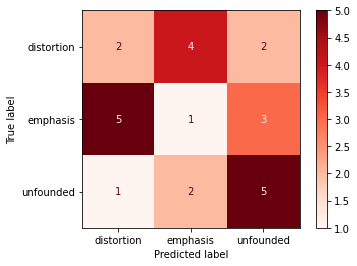

In [16]:
from sklearn.dummy import DummyClassifier

# Dummy Classifier With Method Stratified
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(XTrain, yTrainLabels)

yPredLabels = dummy_clf.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.17      0.12      0.14         8
    emphasis       0.36      0.44      0.40         9
   unfounded       0.12      0.12      0.12         8

    accuracy                           0.24        25
   macro avg       0.22      0.23      0.22        25
weighted avg       0.22      0.24      0.23        25

0.24


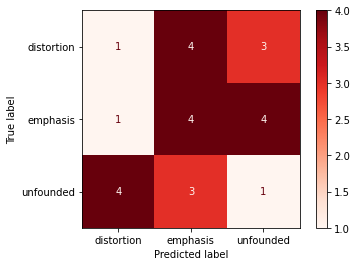

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classification Method
randForestClas = RandomForestClassifier(n_estimators=1000, random_state=0)
randForestClas.fit(XTrain,yTrainLabels)

yPredLabels = randForestClas.predict(XTest)

ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.42      0.62      0.50         8
    emphasis       0.14      0.11      0.12         9
   unfounded       0.00      0.00      0.00         8

    accuracy                           0.24        25
   macro avg       0.19      0.25      0.21        25
weighted avg       0.18      0.24      0.20        25

0.24


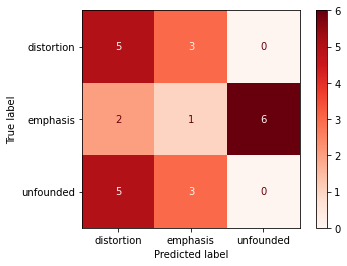

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Classifier
kNeighborsClas = KNeighborsClassifier(n_neighbors=3)
kNeighborsClas.fit(XTrain,yTrainLabels)

yPredLabels = kNeighborsClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.40      0.50      0.44         8
    emphasis       0.43      0.33      0.38         9
   unfounded       0.25      0.25      0.25         8

    accuracy                           0.36        25
   macro avg       0.36      0.36      0.36        25
weighted avg       0.36      0.36      0.36        25

0.36


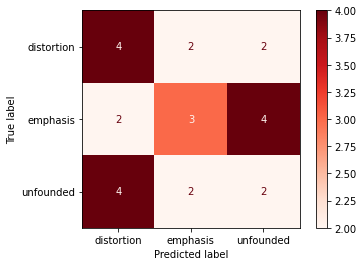

In [19]:
from sklearn.svm import SVC

# SVM Classifier
svmClas = SVC()
svmClas.fit(XTrain,yTrainLabels)

yPredLabels = svmClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.45      0.62      0.53         8
    emphasis       0.50      0.33      0.40         9
   unfounded       0.25      0.25      0.25         8

    accuracy                           0.40        25
   macro avg       0.40      0.40      0.39        25
weighted avg       0.41      0.40      0.39        25

0.4


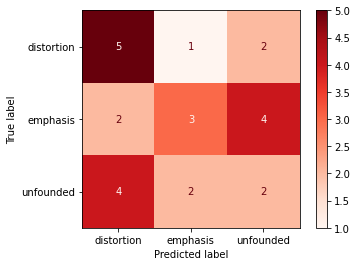

In [20]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier
gaussianProcClas = GaussianProcessClassifier()
gaussianProcClas.fit(XTrain,yTrainLabels)

yPredLabels = gaussianProcClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.29      0.25      0.27         8
    emphasis       0.40      0.44      0.42         9
   unfounded       0.38      0.38      0.38         8

    accuracy                           0.36        25
   macro avg       0.35      0.36      0.35        25
weighted avg       0.36      0.36      0.36        25

0.36


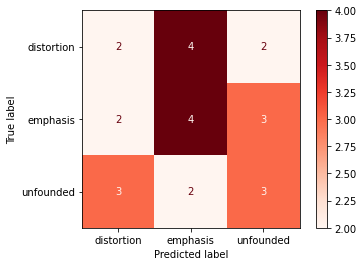

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decisionTreeClas = DecisionTreeClassifier()
decisionTreeClas.fit(XTrain,yTrainLabels)

yPredLabels = decisionTreeClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.00      0.00      0.00         8
    emphasis       0.50      0.33      0.40         9
   unfounded       0.27      0.50      0.35         8

    accuracy                           0.28        25
   macro avg       0.26      0.28      0.25        25
weighted avg       0.27      0.28      0.26        25

0.28


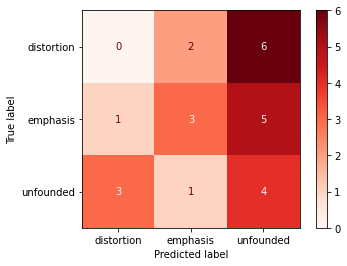

In [22]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier
adaBoostClas = AdaBoostClassifier()
adaBoostClas.fit(XTrain,yTrainLabels)

yPredLabels = adaBoostClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.44      0.50      0.47         8
    emphasis       0.50      0.33      0.40         9
   unfounded       0.40      0.50      0.44         8

    accuracy                           0.44        25
   macro avg       0.45      0.44      0.44        25
weighted avg       0.45      0.44      0.44        25

0.44


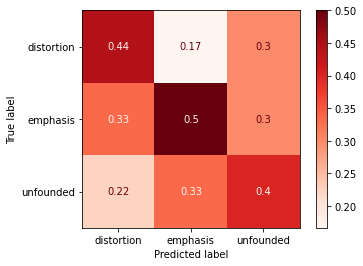

In [23]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Classifier
gaussianNBClas = GaussianNB()
gaussianNBClas.fit(XTrain,yTrainLabels)

yPredLabels = gaussianNBClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds', normalize="pred")
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))